In [1]:
!pip install git+https://github.com/maciejkula/spotlight.git
!pip install git+https://github.com/mangaki/zero
!pip install numpy matplotlib scikit-learn seaborn

  Cloning https://github.com/maciejkula/spotlight.git to /tmp/pip-req-build-97vt1kif
  Running command git clone --filter=blob:none --quiet https://github.com/maciejkula/spotlight.git /tmp/pip-req-build-97vt1kif
  Resolved https://github.com/maciejkula/spotlight.git to commit 75f4c8c55090771b52b88ef1a00f75bb39f9f2a9
  Preparing metadata (setup.py) ... done
  Created wheel for spotlight: filename=spotlight-0.1.6-py3-none-any.whl size=33895 sha256=712a83df09a7602bc8fed973d0f53a16ab9b27d2e7aa3ec4b49ed26f2265ff66
  Stored in directory: /tmp/pip-ephem-wheel-cache-ahg93cgj/wheels/d1/08/ee/45e61c6a791fdd520a5a95479ec9fc0acbbae916ba0456b358
Successfully built spotlight
  Cloning https://github.com/mangaki/zero to /tmp/pip-req-build-amihyb9b
  Running command git clone --filter=blob:none --quiet https://github.com/mangaki/zero /tmp/pip-req-build-amihyb9b
  Resolved https://github.com/mangaki/zero to commit f526bbc538a45bdbe09e82b50c4890e90ea2202b
  Installing build dependencies ... done
  Getti

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2024-12-26 08:41:54--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  4.91MB/s    in 1.0s    

2024-12-26 08:41:56 (4.91 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, linear_kernel
from sklearn.linear_model import Ridge
from zero.svd import MangakiSVD

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
import tensorflow as tf
from tensorflow.keras import layers

# Load the MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=('user', 'item', 'rating', 'timestamp'))
titles = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin1', names=('item', 'title', 'date', 'wat', 'link') + tuple(range(19)))
titles = titles[['item', 'title']]

# Zero-index the user and item columns
ratings['user'] = ratings['user'] - 1
ratings['item'] = ratings['item'] - 1

# Convert to numpy arrays
y = ratings['rating'].to_numpy()  # 1D array of ratings
X = ratings[['user', 'item']].to_numpy()  # 2D array of (user, item)

# Initialize SVD model
# Assume MangakiSVD is already defined
model = MangakiSVD(nb_components=10)
model.nb_users = ratings['user'].max() + 1
model.nb_works = ratings['item'].max() + 1
model.fit(X, y)

# Get item embeddings and user embeddings from the trained model
embeddings_I = model.VT.T * model.sigma
embeddings_U = model.U

embeddings_I = embeddings_I[:20]
embeddings_U = embeddings_U[:20]


Computing M: (943 × 1682)
Shapes (943, 10) (10,) (10, 1682)


In [ ]:
# Define the Graph Neural Network Model
class GNN(tf.keras.Model):
    def __init__(self, num_features, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = layers.Dense(hidden_channels, activation='relu')
        self.conv2 = layers.Dense(hidden_channels, activation='relu')

    def call(self, x, adjacency_matrix):
        x = self.conv1(tf.matmul(adjacency_matrix, x))
        x = self.conv2(tf.matmul(adjacency_matrix, x))
        return x

# Generate a low-discrepancy point set (sample points) using GNN
def generate_diverse_recommendations(item_embeddings, adjacency_matrix, num_recommendations=5):
    model = GNN(num_features=item_embeddings.shape[1], hidden_channels=64)

    # Forward pass to get item representations
    item_embeddings_tensor = tf.convert_to_tensor(item_embeddings, dtype=tf.float32)
    gnn_output = model(item_embeddings_tensor, adjacency_matrix)

    # Compute diversity by selecting items that are spaced apart in the feature space
    distances = tf.norm(tf.expand_dims(gnn_output, 1) - gnn_output, axis=2)
    selected_indices = []

    while len(selected_indices) < num_recommendations:
        if len(selected_indices) == 0:
            idx = np.random.choice(len(item_embeddings))
        else:
            # Select item with maximum distance from already selected items
            #idx = tf.argmax(tf.reduce_sum(distances[:, selected_indices], axis=1)).numpy()
            idx = tf.argmax(tf.reduce_sum(tf.gather(distances, selected_indices, axis=1), axis=0)).numpy()

        if idx not in selected_indices:  # Ensure not to select the same item
            selected_indices.append(idx)

    return selected_indices

# Example usage
user_id = 0  # Example user ID
user_embedding = embeddings_U[user_id].reshape(1, -1)
user_item_similarities = linear_kernel(user_embedding, embeddings_I).flatten()  # Compute user-item similarities
dissimilarity_matrix = linear_kernel(embeddings_I)

# Using embeddings and adjacency matrix to generate diverse recommendations
recommended_indices = generate_diverse_recommendations(embeddings_I, dissimilarity_matrix, num_recommendations=7)
print("Recommended item indices:", recommended_indices)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use PCA to reduce item embeddings to 2D for visualization
def reduce_to_2d(embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    return embeddings_2d

# Example function to visualize the items
def visualize_recommendations(item_embeddings, recommended_indices):
    # Reduce item embeddings to 2D
    embeddings_2d = reduce_to_2d(item_embeddings)

    # Create a plot
    plt.figure(figsize=(10, 8))

    # Plot the non-recommended items in blue
    non_recommended_indices = [i for i in range(item_embeddings.shape[0]) if i not in recommended_indices]
    plt.scatter(embeddings_2d[non_recommended_indices, 0], embeddings_2d[non_recommended_indices, 1],
                c='blue', label='Non-Recommendations', alpha=0.5)

    # Plot the recommended items in red
    plt.scatter(embeddings_2d[recommended_indices, 0], embeddings_2d[recommended_indices, 1],
                c='red', label='Recommendations', s=100, edgecolors='black')

    # Add labels and title
    plt.title('Item Recommendations (Red) vs Non-Recommendations (Blue)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # Show the plot
    plt.show()

# Visualize the recommended items
visualize_recommendations(item_embeddings=embeddings_I, recommended_indices=recommended_indices)


In [5]:
import numpy as np
from scipy.linalg import det

def compute_probability(subset, L):
    # Compute the determinant of the submatrix L_Y
    if len(subset) == 0:
        return 1
    #print(np.ix_(subset, subset))
    submatrix = L[np.ix_(subset, subset)]
    return det(submatrix)

Recommended item indices: [8, 55, 49, 12, 21, 54, 39, 0, 10, 7]


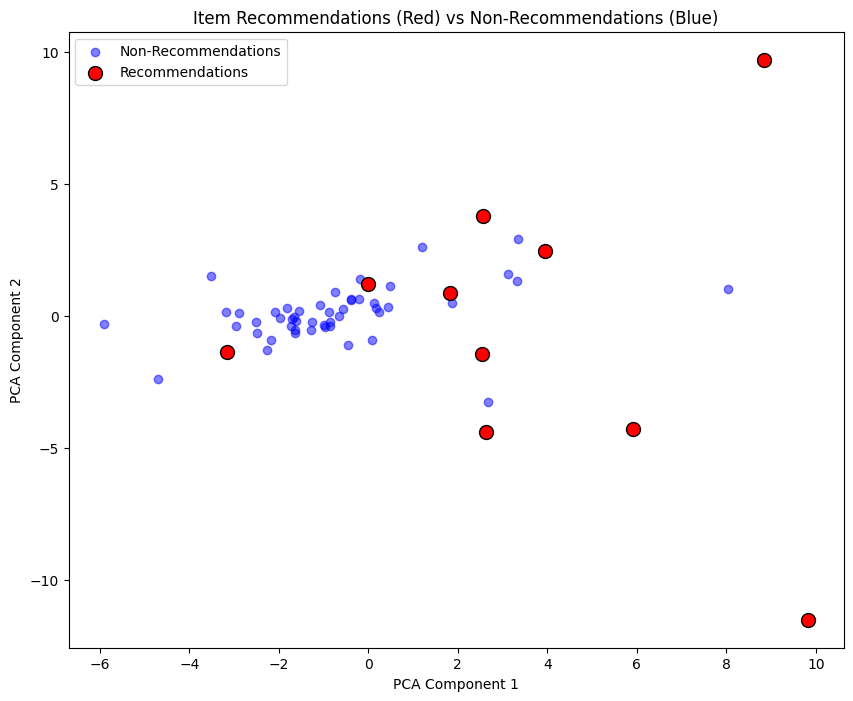

In [6]:
# Define the Graph Neural Network Model
class GNN(tf.keras.Model):
    def __init__(self, num_features, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = layers.Dense(hidden_channels, activation='relu')
        self.conv2 = layers.Dense(hidden_channels, activation='relu')

    def call(self, x, adjacency_matrix):
        x = self.conv1(tf.matmul(adjacency_matrix, x))
        x = self.conv2(tf.matmul(adjacency_matrix, x))
        return x

# Generate a low-discrepancy point set (sample points) using GNN
def generate_diverse_recommendations(item_embeddings, kernel_matrix, num_recommendations=5):
    """
    Generate diverse recommendations using DPP sampling.
    Args:
    - item_embeddings: The embeddings of the items.
    - kernel_matrix: Precomputed similarity (kernel) matrix for DPP sampling.
    - num_recommendations: Number of diverse items to recommend.

    Returns:
    - selected_indices: Indices of selected items.
    """
    selected_indices = []
    all_indices = np.arange(len(item_embeddings))

    while len(selected_indices) < num_recommendations:
        available_indices = [i for i in all_indices if i not in selected_indices]

        # Initialize probabilities for available items
        probabilities = []
        for idx in available_indices:
            new_subset = selected_indices + [idx]
            prob = compute_probability(new_subset, kernel_matrix)
            probabilities.append(prob)

        # Normalize probabilities
        probabilities = np.array(probabilities)
        probabilities /= probabilities.sum()

        # Select an item based on the computed DPP probabilities
        chosen_idx = np.random.choice(available_indices, p=probabilities)
        selected_indices.append(chosen_idx)

    return selected_indices

# Example usage
user_id = 0  # Example user ID
user_embedding = embeddings_U[user_id].reshape(1, -1)
user_item_similarities = linear_kernel(user_embedding, embeddings_I).flatten()  # Compute user-item similarities
dissimilarity_matrix = linear_kernel(embeddings_I)

# Using embeddings and adjacency matrix to generate diverse recommendations
recommended_indices = generate_diverse_recommendations(embeddings_I, dissimilarity_matrix, num_recommendations=10)
print("Recommended item indices:", recommended_indices)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use PCA to reduce item embeddings to 2D for visualization
def reduce_to_2d(embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    return embeddings_2d

# Example function to visualize the items
def visualize_recommendations(item_embeddings, recommended_indices):
    # Reduce item embeddings to 2D
    embeddings_2d = reduce_to_2d(item_embeddings)

    # Create a plot
    plt.figure(figsize=(10, 8))

    # Plot the non-recommended items in blue
    non_recommended_indices = [i for i in range(item_embeddings.shape[0]) if i not in recommended_indices]
    plt.scatter(embeddings_2d[non_recommended_indices, 0], embeddings_2d[non_recommended_indices, 1],
                c='blue', label='Non-Recommendations', alpha=0.5)

    # Plot the recommended items in red
    plt.scatter(embeddings_2d[recommended_indices, 0], embeddings_2d[recommended_indices, 1],
                c='red', label='Recommendations', s=100, edgecolors='black')

    # Add labels and title
    plt.title('Item Recommendations (Red) vs Non-Recommendations (Blue)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # Show the plot
    plt.show()

# Visualize the recommended items
visualize_recommendations(item_embeddings=embeddings_I, recommended_indices=recommended_indices)
